In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from test_functions import problem_setup
from colour import Color
from sim_helpers import (
    fit_outcome_model,
    gen_random_candidates,
    fit_pref_model,
    gen_rand_X,
    PosteriorMeanDummySampler,
    gen_comps,
    gen_expected_util_candidates
)
from botorch.optim.optimize import optimize_acqf

from helper_classes import LearnedPrefereceObjective
from botorch.sampling.samplers import MCSampler, SobolQMCNormalSampler
from botorch.acquisition.utils import prune_inferior_points
from botorch.acquisition.monte_carlo import (
    qNoisyExpectedImprovement,
    qSimpleRegret,
)

import numpy as np
import pandas as pd
from botorch.test_functions.multi_objective import DTLZ2
from torch.distributions import MultivariateNormal

mpl.rcParams["figure.dpi"]= 120
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False

import warnings
warnings.filterwarnings(
    "ignore",
    message="Could not update `train_inputs` with transformed inputs",
)

warnings.filterwarnings(
    "ignore",
    message="NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal",
)


In [2]:
X_dim = 3
Y_dim = 2
problem = DTLZ2(dim=X_dim, num_objectives=Y_dim, noise_std=0)
def util_func(Y):
    mean = torch.tensor([0.5, 1]).double()
    diag_mat = torch.diag(torch.tensor([1, 1.5]))
    theta = torch.tensor(0.4)
    R = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    covar = (R @ diag_mat @ R.T).double()
    mn = MultivariateNormal(loc=mean, covariance_matrix=covar)
    return mn.log_prob(Y)

In [3]:
# Find out feasible Y
n_mc = 1024
mc_X = gen_rand_X(n_mc, problem)
mc_Y = problem(mc_X)
mc_util = mc_Y.sum(dim=-1)

# Simulate preference heatmap
repeated_Ys = []
ymin, ymax = -1, 2.5
util_min = util_func(mc_Y).min()
for y1 in np.arange(ymin, ymax, 0.1):
    for y2 in np.arange(ymin, ymax, 0.1):
        util_val = util_func(torch.tensor([y1, y2]))
        int_util_val = ((util_val - util_min) * 20).clamp(min=0).round().int()
        single_Y = torch.tensor([y1, y2])
        repeated_Ys.append(single_Y.repeat(int_util_val, 1))
repeated_Ys = torch.cat(repeated_Ys)
print(repeated_Ys.shape)

torch.Size([2668, 2])


In [8]:
torch.manual_seed(2)

EUBO_X = []
EUBO_Y = []
feasible_sample_Y = []

# Outcome points
outcome_X = gen_rand_X(8, problem)
outcome_Y = problem(outcome_X)
outcome_util = util_func(outcome_Y)
outcome_comps = gen_comps(utility=outcome_util, comp_noise_type="constant", comp_noise=0)
outcome_model = fit_outcome_model(outcome_X, outcome_Y, X_bounds=problem.bounds)

train_Y = outcome_model.posterior(gen_rand_X(2, problem)).mean.detach()
train_util = util_func(train_Y)
train_comps = gen_comps(utility=train_util, comp_noise_type="constant", comp_noise=0)
post = outcome_model.posterior(mc_X)

for i in range(10):
    print(i)

    pref_model = fit_pref_model(
        train_Y, 
        train_comps, 
        kernel="default", 
        transform_input=True, 
        Y_bounds=torch.stack([torch.zeros(Y_dim), mc_Y.max(dim=-2).values * 1.2])
    )

    cand_X, cand_Y, acqf_val, acqf = gen_expected_util_candidates(
        outcome_model=outcome_model,
        pref_model=pref_model,
        problem=problem,
        previous_winner=None,
        search_space_type="rff",
        return_acqf=True
    )

    EUBO_X.append(cand_X)
    EUBO_Y.append(cand_Y)
    
    # EUBO-f
    feasible_sample_Y.append(acqf.gp_samples.posterior(mc_X).mean.squeeze(0).clone().detach())
    
    train_Y = torch.cat((train_Y, cand_Y))
    train_util = util_func(train_Y)
    train_comps = gen_comps(utility=train_util, comp_noise_type="constant", comp_noise=0)

0
1
2
3
4
5
6
7
8
9


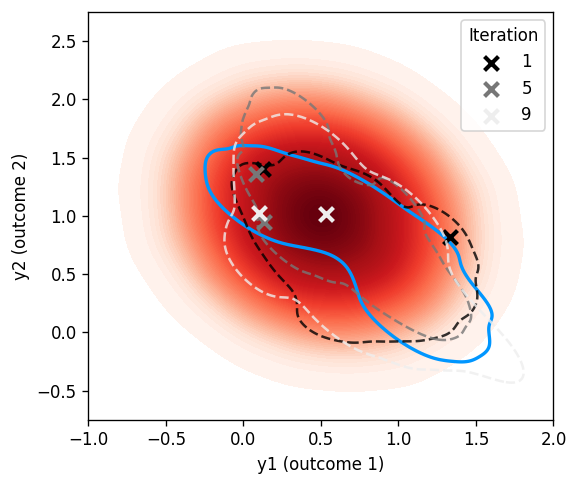

In [9]:
plot_EUBO_Y = torch.cat(EUBO_Y).detach().numpy()

plot_every_n = 4
n_iter_to_plot = plot_EUBO_Y.shape[0] // (plot_every_n * 2) + 1
plot_idx = [i * plot_every_n for i in range(n_iter_to_plot)]
pair_plot_idx = np.array([(2 * plot_every_n * i, 2 * plot_every_n * i + 1) for i in range(n_iter_to_plot)]).flatten()
plot_EUBO_Y = plot_EUBO_Y[pair_plot_idx, :]

cmap = "Reds"
ftrue_color = "#0096FF"
init_color = Color("#000000")
final_color = Color("#eeeeee")
colors = [c.hex_l for c in init_color.range_to(final_color, plot_EUBO_Y.shape[0]//2)]
pair_colors = np.repeat(colors, 2)

plot_ymin, plot_ymax = ymin, ymax
fig, ax = plt.subplots(figsize=(5, 4.5))

sns.kdeplot(x=repeated_Ys[:,0], y=repeated_Ys[:,1], cmap=cmap, shade=True, levels=100, ax=ax, thresh=0.001)
sns.kdeplot(x=mc_Y[:,0], y=mc_Y[:,1], levels=1, ax=ax, color=ftrue_color, thresh=0.005, linewidths=2)
for i, idx in enumerate(plot_idx):
    sns.kdeplot(x=feasible_sample_Y[idx][:,0], y=feasible_sample_Y[idx][:,1], levels=1, ax=ax, color=colors[i], thresh=0.005, alpha=0.8, linewidths=1.5, linestyles="--", zorder=i + 10)
    ax.scatter(x=plot_EUBO_Y[[i*2, i*2+1], 0], y=plot_EUBO_Y[[i*2, i*2+1], 1], marker="x", s=70, linewidths=2.5, color=colors[i], alpha=1, zorder=i + 10, label=idx + 1)

ax.set_xlim(-1, 2.0)
ax.set_ylim(-0.75, 2.75)
ax.set_xlabel("y1 (outcome 1)")
ax.set_ylabel("y2 (outcome 2)")
plt.legend(title="Iteration")

plt.savefig("../plots/example_eubo.pdf", bbox_inches='tight')